In [1]:
import pandas as pd
import plotly.graph_objects as go # type: ignore

In [40]:
import os
import warnings
warnings.filterwarnings("ignore")
os.chdir("../database")
list_ = os.listdir()
# database: price_fund 
parquet_price_fund = []
for i in list_:
    if "tw_price_fund" in i: 
        parquet_price_fund.append(i)        
df_list = [pd.read_parquet(i) for i in parquet_price_fund]
unpivoted_df = pd.concat(df_list)
twa00 = unpivoted_df[unpivoted_df['code'] == "TWA00"].set_index('da').sort_index(ascending=True).iloc[:, 1]

<Axes: xlabel='da'>

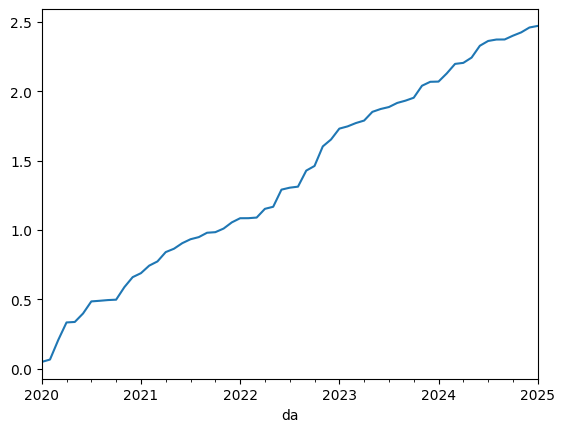

In [91]:
time_ = "2018-10-15"; end_ = '2025-01-24'
twa00_m = twa00.pct_change().resample("ME").sum()
ln_ = twa00_m
k = ln_.apply(lambda x: -1 if x < 0 else 1)
pct_calculating_profit = twa00_m.shift(0)
res = k*pct_calculating_profit.shift(0)

res.cumsum().plot()

In [90]:
import numpy as np
res_df = pd.DataFrame()
res_df['signal'] = k
res_df['pct'] = pct_calculating_profit
res_df['pct'] = res_df['pct'].shift(-2)
res_df.dropna(inplace=True)
np.corrcoef(res_df.T)

array([[1.        , 0.03896938],
       [0.03896938, 1.        ]])

In [48]:
import matplotlib.pyplot as plt
import yfinance as yf
twii = yf.download("^TWII", start='2016-01-01', rounding=2, progress=False)[['Close']]
df = pd.DataFrame(twii)
# df = pd.DataFrame(twa00)
df.columns = ["price"]
df = df.resample("ME").sum()
df['pct'] = df.price.pct_change()
df['cumsum'] =df.pct.cumsum()
df['stDev'] = df.pct.rolling(5).std()
df['ir'] = df.pct/df.stDev
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df['cumsum'],
        mode="lines",
        name="Cumulative Percentage Change",
        yaxis="y1",  # Map to primary y-axis
        line=dict(color="blue")
    )
)

# Add scatter plot (or histogram) for IR
fig.add_trace(
    go.Bar(
        x=df.index,
        y=df['ir'],
        name="Information Ratio (Bar)",
        yaxis="y2",  # Map to secondary y-axis
        marker=dict(color="red", opacity=0.6)
    )
)

# Set up layout with dual y-axes
fig.update_layout(
    title="Cumulative % Change vs Information Ratio",
    xaxis=dict(title="Date"),
    yaxis=dict(
        title="Cumulative % Change",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue")
    ),
    yaxis2=dict(
        title="Information Ratio",
        titlefont=dict(color="red"),
        tickfont=dict(color="red"),
        overlaying="y",
        side="right"  # Position y2 axis on the right
    ),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Show the plot
fig.show()


# 動能
# ARMA
# Sharpe(Time-Varying)
# VWAP

# 低波动率指数：表现最为出色，不仅回报率最高，还显著降低了波动率和回撤幅度。
# 高股息指数：在熊市中表现出色，具有防御性特征。
# 动量指数：在牛市中表现更好，但在熊市中可能表现不佳。

[*********************100%***********************]  1 of 1 completed


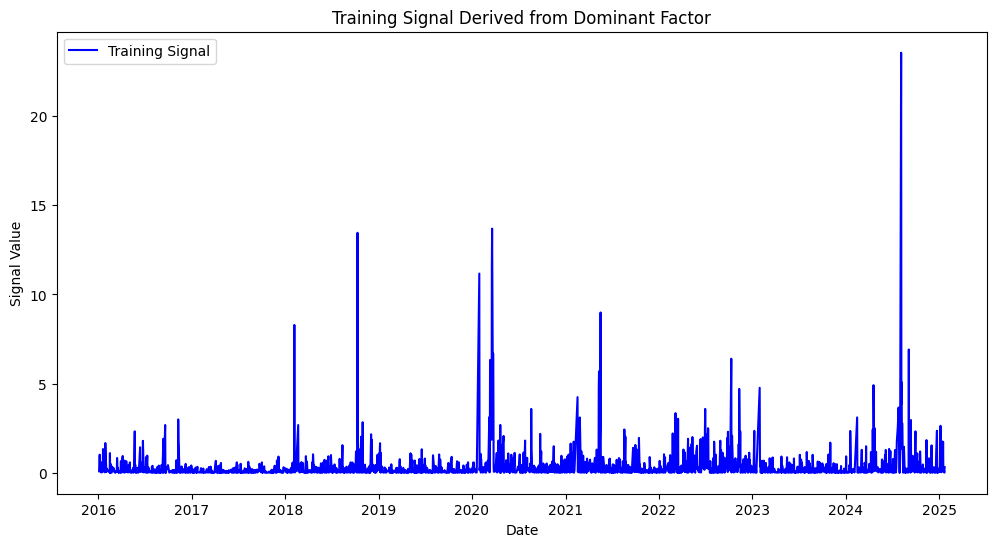

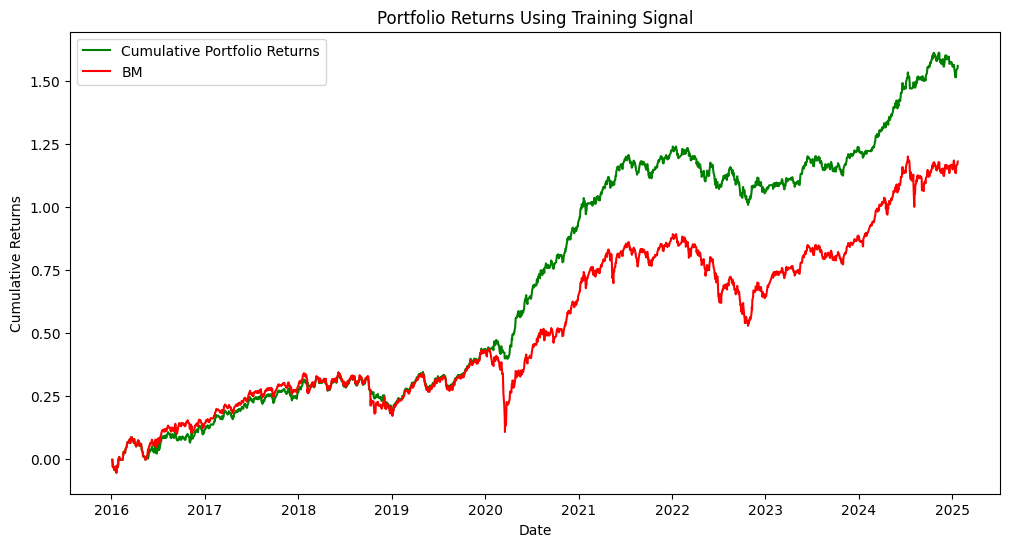

In [104]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

# Step 1: Load data (TAIEX)
data = yf.download("^TWII", start='2016-01-01')
returns = data["Close"].pct_change().dropna()

# Reshape returns to 2D as required by LedoitWolf
returns_2d = returns.values.reshape(-1, 1)

# Step 2: Covariance Matrix
cov_matrix = np.cov(returns_2d, rowvar=False)
lw = LedoitWolf()
cov_matrix_shrinked = lw.fit(returns_2d).covariance_

# Step 3: Spectral Decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix_shrinked)
dominant_factors = eigenvectors[:, -1:]  # Retain the top factor

# Factor Signal as a Training Signal
factor_signal = (returns_2d @ dominant_factors).flatten()  # Flatten to 1D for element-wise multiplication

# Multiply Factor Signal with Returns
training_signal = factor_signal * returns.values  # Element-wise multiplication

# Normalize Training Signal (optional, for scaling purposes)
normalized_signal = training_signal / np.std(training_signal)

# Plot Training Signal
plt.figure(figsize=(12, 6))
plt.plot(data.index[1:], normalized_signal, label="Training Signal", color="blue")
plt.title("Training Signal Derived from Dominant Factor")
plt.xlabel("Date")
plt.ylabel("Signal Value")
plt.legend()
plt.show()

# Optional: Use training_signal as weights in a portfolio
signal = [-1 if i > 2 else 1 for i in normalized_signal]

portfolio_returns = signal * returns.values  # Simulated weighted returns
cumulative_returns = np.cumsum(portfolio_returns)

# Plot Portfolio Performance
plt.figure(figsize=(12, 6))
plt.plot(data.index[1:], cumulative_returns, label="Cumulative Portfolio Returns", color="green")
plt.plot(data.index[1:], data['Close'].pct_change().cumsum().dropna(), label="BM", color="red")
plt.title("Portfolio Returns Using Training Signal")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()
